In [1]:
import torch
import pandas as pd

In [11]:
df = pd.read_csv("artists.csv")
artist_list = df['Artist'].to_list()
concat_lyrics = ''

for artist in artist_list[:17]:
    df = pd.read_csv(f'./lyrics/{artist}.csv')
    concat_lyrics += df['Lyrics'].str.cat(sep='\n\n')


In [44]:
PROMPT = "Kendrick Lamar - The Blacker the Berry"

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


# Generate Album/Song Cover with Stable Diffusion

In [ ]:
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

model_id = "stabilityai/stable-diffusion-2-1"

# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32) # if use cuda, do float16
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
#pipe = pipe.to("cuda")



Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
prompt = "A hiphop album cover for song: Kendrick Lamar - The Blacker the Berry"
image = pipe(prompt).images[0]

image.save("album cover.png")

  0%|          | 0/50 [00:00<?, ?it/s]

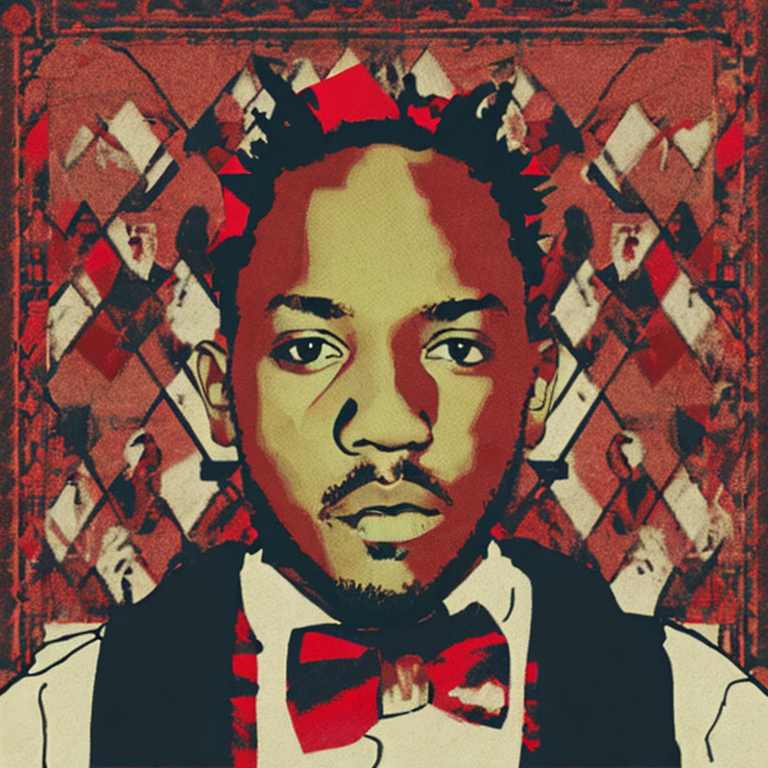

In [ ]:
from IPython.display import Image
Image("album cover.png")

# Generate Hip-Hop Lyrics with fine-tuned nanoGPT

In [45]:
"""
Sample from a trained model
"""
import os
import pickle
from contextlib import nullcontext
import torch
import tiktoken
from nanoGPT.model import GPTConfig, GPT

# -----------------------------------------------------------------------------
init_from = 'resume' # either 'resume' (from an out_dir) or a gpt2 variant (e.g. 'gpt2-xl')
out_dir = 'F:/Python Projects/2023/Spotify-Lyric-Generator/nanoGPT/out-lyrics' # ignored if init_from is not 'resume'
start = PROMPT # or "<|endoftext|>" or etc. Can also specify a file, use as: "FILE:prompt.txt"
num_samples = 1 # number of samples to draw
max_new_tokens = 2500 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 200 # retain only the top_k most likely tokens, clamp others to have 0 probability
seed = 1337
device = 'cpu' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
if device == 'cuda':
    dtype = 'bfloat16' if torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
else:
    dtype = 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = False # use PyTorch 2.0 to compile the model to be faster
# exec(open('./nanoGPT/configurator.py').read()) # overrides from command line or config file
# -----------------------------------------------------------------------------

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

# model
if init_from == 'resume':
    # init from a model saved in a specific directory
    ckpt_path = os.path.join(out_dir, 'ckpt.pt')
    checkpoint = torch.load(ckpt_path, map_location=device)
    gptconf = GPTConfig(**checkpoint['model_args'])
    model = GPT(gptconf)
    state_dict = checkpoint['model']
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model.load_state_dict(state_dict)
elif init_from.startswith('gpt2'):
    # init from a given GPT-2 model
    model = GPT.from_pretrained(init_from, dict(dropout=0.0))

model.eval()
model.to(device)
if compile:
    model = torch.compile(model) # requires PyTorch 2.0 (optional)

# look for the meta pickle in case it is available in the dataset folder
load_meta = False
if init_from == 'resume' and 'config' in checkpoint and 'dataset' in checkpoint['config']: # older checkpoints might not have these...
    meta_path = os.path.join('nanoGPT/data', checkpoint['config']['dataset'], 'meta.pkl')
    load_meta = os.path.exists(meta_path)
if load_meta:
    print(f"Loading meta from {meta_path}...")
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    # TODO want to make this more general to arbitrary encoder/decoder schemes
    stoi, itos = meta['stoi'], meta['itos']
    encode = lambda s: [stoi[c] for c in s]
    decode = lambda l: ''.join([itos[i] for i in l])
else:
    # ok let's assume gpt-2 encodings by default
    print("No meta.pkl found, assuming GPT-2 encodings...")
    enc = tiktoken.get_encoding("gpt2")
    encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
    decode = lambda l: enc.decode(l)

# encode the beginning of the prompt
if start.startswith('FILE:'):
    with open(start[5:], 'r', encoding='utf-8') as f:
        start = f.read()
start_ids = encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

# run generation
with torch.no_grad():
    with ctx:
        for k in range(num_samples):
            y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
            print(decode(y[0].tolist()))
            print('---------------')
            f = open('generated_lyrics.txt', 'wb')
            f.write(decode(y[0].tolist()).encode("utf8"))


number of parameters: 0.80M
Loading meta from nanoGPT/data\lyrics\meta.pkl...
Kendrick Lamar - The Blacker the Berry
I be made in the way, I'l got played to couldn't to like a head most (Yeah)
Wrong mootins
Now a all oneson That main
A yearsty (Woo)
Never on me was
Boy, call you gotta sex like the napper (Dim, yeah)
She can't high the hoode (Yeah)
Never gotta got for the drop, at? (Whole)
Now you know whew is them stoped look (SDoy, it song)
I'm one every (Yeah)
I know the way out a wanta rocket, ooh ('No, I walk it)
You know the moment (Could's met, whatever)
I don't want to keep so almory (What?")
I got a get the hood a get up (Woop)
Prold of this don't do show up, she get out that call them hide world?
My 40 baby, I can't be bare for this some deal
I sweet for got no with the four it of Shey could up
Maybe I'm jumpoting I bought still swear a cartifere
Only momens had do my momight
They boy in on my come in to heard the rademin'
Be me sonce her sorry tow
Watch that's a pain with tha